In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

%matplotlib inline

bengin_path = './The IQ-OTHNCCD lung cancer dataset/Bengin cases'
malignant_path = './The IQ-OTHNCCD lung cancer dataset/Malignant cases'
normal_path = './The IQ-OTHNCCD lung cancer dataset/Normal cases'

print("Current Working Directory:", os.getcwd())

for path in [bengin_path, malignant_path, normal_path]:
    if not os.path.exists(path):
        print(f"Directory not found: {path}")
    else:
        print(f"Directory found: {path}")

        img_classes = ["Bengin cases", "Malignant cases", "Normal cases"]
        path_list = [bengin_path, malignant_path, normal_path]

        img_path = []
        class_labels = []
        for i, dir_list in enumerate(path_list):

            name_img = os.listdir(dir_list)
            for name_file in name_img:
                img = os.path.join(dir_list,name_file)
                img_path.append(img)
                class_labels.append(img_classes[i])

df = pd.DataFrame({"img_path" : img_path,
                  "label" : class_labels})

df.head()


Current Working Directory: /Users/manitatamang/Desktop/dissertation/notebook
Directory found: ./The IQ-OTHNCCD lung cancer dataset/Bengin cases
Directory found: ./The IQ-OTHNCCD lung cancer dataset/Malignant cases
Directory found: ./The IQ-OTHNCCD lung cancer dataset/Normal cases


,img_path,label
0,./The IQ-OTHNCCD lung cancer dataset/Bengin ca...,Bengin cases
1,./The IQ-OTHNCCD lung cancer dataset/Bengin ca...,Bengin cases
2,./The IQ-OTHNCCD lung cancer dataset/Bengin ca...,Bengin cases
3,./The IQ-OTHNCCD lung cancer dataset/Bengin ca...,Bengin cases
4,./The IQ-OTHNCCD lung cancer dataset/Bengin ca...,Bengin cases


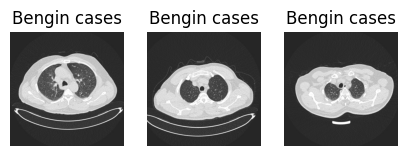

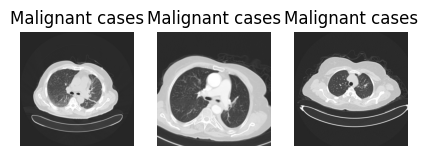

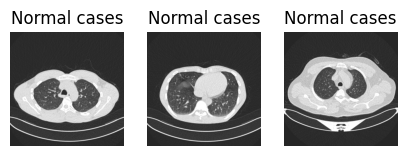

In [20]:
for category, group in df.groupby("label"):
    fig, ax = plt.subplots(1,3, figsize = (5,5))
    ax = ax.ravel()
    for i, (_,r) in enumerate(group.sample(3).iterrows()):
        img = cv2.imread(r.img_path)
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title(r.label)
    plt.show()

In [21]:
countData = df["label"].value_counts().reset_index()
countData.columns = ['label', 'count']
print(countData)
fig = px.histogram(data_frame = countData, x = "label", y = "count")
fig.show()

             label  count
0  Malignant cases    561
1     Normal cases    416
2     Bengin cases    120


In [22]:
import nbformat
print(nbformat.__version__)

5.10.4


In [23]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

2.19.0
3.9.2


In [24]:
sizes = []
resolutions = []
color_distrubtions = []

for img_path in df["img_path"]:
    img = cv2.imread(img_path)
    size = os.path.getsize(img_path)
    sizes.append(size)
    resolution = img.shape[:2]
    resolutions.append(resolution)
    mean_color_distrubtions = np.bincount(img.flatten(),minlength=256)
    color_distrubtions.append(mean_color_distrubtions)
sizes = np.array(sizes)
resolutions = np.array(resolutions)
mean_color_distrubtions = np.array(color_distrubtions)

In [25]:
sizes_MB = []
for img_path in df["img_path"]:
    img = cv2.imread(img_path)
    size = os.path.getsize(img_path)
    sizes_MB.append(size/1_000_000)

fig = px.histogram(x=sizes_MB, nbins=50, title="Distrubtion of image sizes")
fig.update_layout(xaxis_title = "File Size (MB)",
                  yaxis_title = "Number of Images",
                  showlegend = False,
                  bargap = 0.1,
                  bargroupgap = 0.1)
fig.update_traces(marker=dict(color="green"))
fig.show()

In [26]:
fig = px.scatter(x = resolutions[:,0], y=resolutions[:,1], title="Distribution of Image resolution")
fig.update_layout(
    xaxis_title="Width (Pixel)",
    yaxis_title="Height (Pixel)",
    showlegend = False,
    hovermode="closest"
)
fig.update_traces(marker=dict(color="red"))
fig.show()

In [27]:
mean_color_distrubtions = np.mean(color_distrubtions, axis = 0)
fig = go.Figure(
    go.Bar(x=np.arange(256), y=mean_color_distrubtions, name="Mean Color Distrubtions")
)
fig.update_layout(
    title="Mean Color Distrubtion",
    xaxis_title="Color Values",
    yaxis_title="Number of Pixel"
)
fig.show()

Train Test Split

In [28]:
train_ratio = 0.70
test_ratio = 0.15
val_ratio = 0.15

df_train, df_test_val = train_test_split(df, train_size = train_ratio, random_state = 42)
df_test, df_val = train_test_split(df_test_val, train_size = test_ratio/(test_ratio+val_ratio), random_state = 42)

print(f"Train shape = {df_train.shape}")
print(f"Test shape = {df_test.shape}")
print(f"Validation shape = {df_val.shape}")


Train shape = (767, 2)
Test shape = (165, 2)
Validation shape = (165, 2)


Denoise Image Using Median Blur

In [29]:
def preprocessing_denoise(img):
    denoise_img = cv2.medianBlur(img, 1)
    denoise_img = cv2.cvtColor(denoise_img, cv2.COLOR_BGR2RGB)
    return denoise_img

Image Data Augmentation using ImageDataGenerator

In [50]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
image_size = (IMG_WIDTH, IMG_HEIGHT)
batch_size = 32
TRAIN_DATAGEN = ImageDataGenerator(rescale=1./255.,
                                   preprocessing_function = preprocessing_denoise,
                                   rotation_range = 20,
                                   width_shift_range = 0.1, height_shift_range = 0.2,
                                   shear_range = 0.05, zoom_range = 0.1,
                                   horizontal_flip = True)
TEST_DATAGEN = ImageDataGenerator(rescale=1./255.)
VAL_DATAGEN = ImageDataGenerator(rescale=1./255.,
                                 preprocessing_function = preprocessing_denoise)
train_generator = TRAIN_DATAGEN.flow_from_dataframe(
    df_train, x_col = "img_path", y_col = "label",
    target_size = image_size, batch_size = batch_size,
    color_mode = 'rgb', class_mode = "categorical",
    shuffle = True
)

val_generator = VAL_DATAGEN.flow_from_dataframe(
    df_val, x_col = "img_path", y_col = "label",
    target_size = image_size, batch_size = batch_size,
    color_mode = "rgb", class_mode = "categorical",
    shuffle = True
)

test_generator = TEST_DATAGEN.flow_from_dataframe(
    df_test, x_col = "img_path", y_col = "label",
    target_size = image_size, batch_size = batch_size,
    color_mode = "rgb", class_mode = "categorical",
    shuffle = False
)

Found 767 validated image filenames belonging to 3 classes.
Found 165 validated image filenames belonging to 3 classes.
Found 165 validated image filenames belonging to 3 classes.


Class Weights

In [51]:
classes = ['Bengin cases', 'Malignant cases', 'Normal cases']

class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(train_generator.classes),
    y = train_generator.classes
)
train_class_weights = dict(enumerate(class_weights))
for idx, weight, in train_class_weights.items():
    class_name = classes[idx]
    print(f"{class_name} : {weight}")

Bengin cases : 3.1958333333333333
Malignant cases : 0.6606373815676141
Normal cases : 0.8522222222222222


Model

CNN

In [52]:
model1 = Sequential([
    Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), input_shape = (224,224,3), activation = 'relu', padding = "same"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),
    
    Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Flatten(),
    Dense(4096, activation = "relu"),
    Dropout(0.5),
    Dense(256),
    Dropout(0.25),
    Dense(3, activation = "softmax")
    
])
model1.summary()

/Users/manitatamang/Desktop/dissertation/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_194 (Conv2D)             │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_194         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_195 (Conv2D)             │ (None, 110, 110, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_195         │ (None, 55, 55, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_196 (Conv2D)             │ (None, 53, 53, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_196         │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_197 (Conv2D)             │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_197         │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_198 (Conv2D)             │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_198         │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_199 (Conv2D)             │ (None, 3, 3, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_199         │ (None, 1, 1, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │     1,048,83

 Total params: 3,251,267 (12.40 MB)

 Trainable params: 3,249,475 (12.40 MB)

 Non-trainable params: 1,792 (7.00 KB)

Training Model

In [56]:
model1.compile(
    loss = "categorical_crossentropy",
    optimizer = Adam(learning_rate = 0.0005),
    metrics = ['accuracy']
)
epochs = 50
history = model1.fit(train_generator,
                     steps_per_epoch = len(train_generator),
                     batch_size = 32,
                     validation_data = val_generator,
                     validation_steps = len(val_generator),
                     class_weight = train_class_weights,
                     callbacks = [
                        EarlyStopping(monitor = "val_loss",
                        patience = 5,
                        restore_best_weights = True),
                        ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 2, mode = 'min')
                     ],
                     epochs = epochs)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5720 - loss: 1.5923 - val_accuracy: 0.3636 - val_loss: 2.2013 - learning_rate: 5.0000e-04
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6428 - loss: 1.1639 - val_accuracy: 0.5273 - val_loss: 3.4250 - learning_rate: 5.0000e-04
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6806 - loss: 1.3155 - val_accuracy: 0.5576 - val_loss: 3.0286 - learning_rate: 5.0000e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6735 - loss: 0.9852 - val_accuracy: 0.6000 - val_loss: 1.2855 - learning_rate: 2.5000e-04
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7345 - loss: 0.8877 - val_accuracy: 0.4667 - val_loss: 1.4335 - learning_rate: 2.5000e-04
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7251 - loss: 0.8337 - val_accuracy: 0.5394 - val_loss: 2.5542 - learning_rate: 2.5000e-04
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7872 - loss:

Accuracy and Loss

In [57]:
def history_plot(epochs, history):
    fig1 = make_subplots()
    fig1.add_trace(go.Scatter(x = np.arange(1,epochs+1),y = history.history["accuracy"], name="training accuracy"))
    fig1.add_trace(go.Scatter(x = np.arange(1,epochs+1),y = history.history["val_accuracy"], name="validation accuracy"))
    fig1.update_layout(title="Training and validation accuracy", xaxis_title = 'Epoch',yaxis_title="accuracy")
    fig1.show()

    fig2 = make_subplots()
    fig2.add_trace(go.Scatter(x = np.arange(1,epochs+1),y = history.history["loss"], name="trainingloss"))
    fig2.add_trace(go.Scatter(x = np.arange(1,epochs+1),y = history.history["val_loss"], name="validation loss"))
    fig2.update_layout(title="Training and validation loss", xaxis_title = 'Epoch',yaxis_title="loss")
    fig2.show()

history_plot(epochs, history)

Evaluate the loss and accuracy

In [58]:
def evaluate_model(model, test_generator):
    results = model.evaluate(test_generator, verbose = 0)
    print(f"Test loss = {results[0]}")
    print(f"Test accuracy = {results[1]}")

evaluate_model(model1, test_generator)

Test loss = 1.281096339225769
Test accuracy = 0.6000000238418579


Training Model InceptionV3

In [ ]:
import certifi
print(certifi.where())

/Users/manitatamang/Desktop/dissertation/.venv/lib/python3.12/site-packages/certifi/cacert.pem


In [ ]:
from tensorflow.keras.applications import InceptionV3, VGG16, ResNet50

base_model = InceptionV3(input_shape = (IMG_WIDTH, IMG_HEIGHT, 3), include_top = False, weights = "imagenet")

for layer in base_model.layers:
    layer.trainable = False

model2 = Sequential()
model2.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model2.add(base_model)
model2.add(Flatten())
model2.add(Dense(1024, activation="relu"))
model2.add(Dropout(0.4))
model2.add(Dense(3, activation="softmax"))

epochs = 50
model2.compile(optimizer = Adam(0.0005),
               loss = "categorical_crossentropy",
               metrics = ["accuracy"])
history = model2.fit(train_generator,
                     steps_per_epoch = len(train_generator),
                     batch_size = 64,
                     validation_data = val_generator, validation_steps = len(val_generator),
                     class_weight = train_class_weights,
                     callbacks = [
                         EarlyStopping(monitor = "val_loss",
                                       patience = 5,
                                       restore_best_weights = True),
                                       ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, mode='min')
                     ],
                     epochs = epochs)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.3752 - loss: 33.2028 - val_accuracy: 0.3758 - val_loss: 4.1846 - learning_rate: 5.0000e-04
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6366 - loss: 4.4476 - val_accuracy: 0.6727 - val_loss: 1.0979 - learning_rate: 5.0000e-04
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6014 - loss: 2.5684 - val_accuracy: 0.8424 - val_loss: 0.3950 - learning_rate: 5.0000e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7763 - loss: 0.7341 - val_accuracy: 0.8424 - val_loss: 0.4672 - learning_rate: 5.0000e-04
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7874 - loss: 0.6207 - val_accuracy: 0.7636 - val_loss: 0.4215 - learning_rate: 5.0000e-04
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7661 - loss: 0.5322 - val_accuracy: 0.7939 - val_loss: 0.4649 - learning_rate: 1.0000e-04
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8123 - loss

In [ ]:
history_plot(epochs, history)

In [38]:
evaluate_model(model2, test_generator)

Test loss = 0.3950498104095459
Test accuracy = 0.842424213886261


Training Model VGG16

In [ ]:
base_model_vgg16 = VGG16(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), include_top=False, weights="imagenet")
for layer in base_model_vgg16.layers:
    layer.trainable = False

model3 = Sequential()
model3.add(Input(shape = (IMG_WIDTH, IMG_HEIGHT, 3)))
model3.add(base_model_vgg16)
model3.add(Flatten())
model3.add(Dense(1024, activation="relu"))
model3.add(Dropout(0.4))
model3.add(Dense(3, activation="softmax"))

model3.compile(optimizer = Adam(0.0005),
               loss = "categorical_crossentropy",
               metrics = ["accuracy"])

epochs = 50
history = model3.fit(train_generator,
                     steps_per_epoch = len(train_generator),
                     batch_size = 64,
                     validation_data = val_generator, 
                     validation_steps = len(val_generator),
                     class_weight = train_class_weights,
                     callbacks = [
                         EarlyStopping(monitor="val_loss",
                         patience = 5,
                         restore_best_weights = True),
                         ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, mode='min')
                     ],
                     epochs = epochs)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 111s 5s/step - accuracy: 0.3888 - loss: 6.5254 - val_accuracy: 0.3333 - val_loss: 2.2735 - learning_rate: 5.0000e-04
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.5778 - loss: 1.3456 - val_accuracy: 0.7576 - val_loss: 0.5320 - learning_rate: 5.0000e-04
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.7020 - loss: 0.8235 - val_accuracy: 0.8000 - val_loss: 0.4933 - learning_rate: 5.0000e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 133s 6s/step - accuracy: 0.6731 - loss: 0.7267 - val_accuracy: 0.9030 - val_loss: 0.3442 - learning_rate: 5.0000e-04
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.7334 - loss: 0.7027 - val_accuracy: 0.8424 - val_loss: 0.3563 - learning_rate: 5.0000e-04
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.7415 - loss: 0.6458 - val_accuracy: 0.7152 - val_loss: 0.5958 - learning_rate: 5.0000e-04
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 137s 6s/step - accuracy: 0.7252 

In [48]:
history_plot(epochs, history)

In [49]:
evaluate_model(model3, test_generator)

Test loss = 0.34416311979293823
Test accuracy = 0.903030276298523


Fine Tuning VGG16 Model

In [44]:
base_model_vgg16.trainable = True
set_trainable = False
for layer in base_model_vgg16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model3.compile(optimizer=Adam(0.00001),
               loss = "categorical_crossentropy",
               metrics = ["accuracy"])

epochs = 50
history = model3.fit(train_generator,
                     steps_per_epoch = len(train_generator),
                     batch_size = 64,
                     validation_data = val_generator,
                     validation_steps = len(val_generator),
                     class_weight = train_class_weights,
                     callbacks = [
                         EarlyStopping(monitor="val_loss",
                         patience = 5,
                         restore_best_weights = True),
                         ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=4, mode="min")
                     ],
                     epochs = epochs)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5139 - loss: 1.5979 - val_accuracy: 0.6182 - val_loss: 0.8648 - learning_rate: 1.0000e-05
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6820 - loss: 0.7786 - val_accuracy: 0.7152 - val_loss: 0.5826 - learning_rate: 1.0000e-05
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6966 - loss: 0.7856 - val_accuracy: 0.7818 - val_loss: 0.4865 - learning_rate: 1.0000e-05
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7544 - loss: 0.8009 - val_accuracy: 0.7879 - val_loss: 0.4840 - learning_rate: 1.0000e-05
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7300 - loss: 0.7420 - val_accuracy: 0.8061 - val_loss: 0.4021 - learning_rate: 1.0000e-05
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8052 - loss: 0.6133 - val_accuracy: 0.8545 - val_loss: 0.3782 - learning_rate: 1.0000e-05
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7840 - loss:

In [59]:
history_plot(epochs, history)

In [60]:
evaluate_model(model3, test_generator)

Test loss = 0.3744284510612488
Test accuracy = 0.8363636136054993


In [42]:
from tensorflow.keras import layers, models

base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(180,180,3))
base_model.trainable = False

model4 = models.Sequential([
    base_model, layers.Flatten(),
    layers.Dense(512, activation="relu"),
    layers.Dense(5,activation="softmax")
])
model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [47]:
models = [model1, model2, model3]
loss = []
accuracy = []
for model in models:
    results = model.evaluate(test_generator, verbose = 0)
    loss.append(results[0])
    accuracy.append(results[1])

name_models = ["CNN (Custom)", "InceptionV3", "VGG16", "ResNet50"]
df_loss_acc = pd.DataFrame(data = {"Name_Models" : name_models,
                                  "Loss" : loss,
                                  "Accuracy" : accuracy})

fig = px.bar(data_frame = df_loss_acc, x = "Name_Models", y = ["Accuracy", "Loss"],
            barmode = "group",
            text_auto = ".3f")
fig.show()

ValueError: All arrays must be of the same length